In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.linalg as la
from scipy.stats import zscore
import seaborn as sns
from tqdm import trange

In [2]:
import biosfa

# Generating the timeseries

In [3]:
rg = np.random.default_rng(0)

In [4]:
# time domain length
T = 10**6
# window size
m = 4
# monomial expansion order
order = 2

In [5]:
def sum_sines(T=6000, n_sines=6, period=100):
    domain = np.arange(T) / period
    rates = rg.uniform(0.5, 1.25, size=n_sines)
    offsets = rg.uniform(2 * period, size=n_sines)
    amplitudes = rg.uniform(0.1, 2.0, size=n_sines)
    amplitudes /= amplitudes.sum()
    return (
        amplitudes[:, None]
        * np.sin(rates[:, None] * np.add.outer(offsets, domain))
    ).sum(axis=0)

def logisticmap(gamma, s_0=0.6):
    out = np.zeros_like(gamma)
    s = s_0
    for i, g in enumerate(gamma):
        out[i] = s = (3.7 + 0.35 * g) * s * (1 - s)
    return out

In [6]:
# driving force: this is what we want to recover
driving = sum_sines(T=(T + m - 1)) / 1.25
# slow feature drives a chaotic iterated map
series = logisticmap(driving)

In [7]:
# this is what we want to recover
true_s_plot = zscore(driving[-5000 - m + 1:-m + 1])
# fix sign ambiguity
true_s_plot *= np.sign(true_s_plot[0])

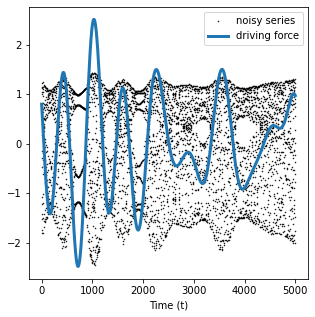

In [8]:
plt.figure(figsize=(5,5))
# zscore to plot everyone togethera
plt.plot(zscore(series[-5000:]), "k.", ms=1.0, label="noisy series")
plt.plot(true_s_plot, lw=3, label="driving force")
plt.xlabel("Time (t)")
plt.legend()

In [9]:
# rolling window expansion and whitening
signal = np.array([series[i : i + m] for i in range(T)])
signal = signal - np.mean(signal, axis=0)
signal = signal @ la.inv(la.sqrtm(np.cov(signal.T)))

In [10]:
# quadratic expansion
k = np.int(m+m*(m+1)/2)
X = np.zeros((k,T))
X[0:m,:] = signal.T
for t in range(T):
    X[m,t] = signal[t,0]*signal[t,0]
    X[m+1,t] = signal[t,1]*signal[t,0]
    X[m+2,t] = signal[t,1]*signal[t,1]
    X[m+3,t] = signal[t,2]*signal[t,0]
    X[m+4,t] = signal[t,2]*signal[t,1]
    X[m+5,t] = signal[t,2]*signal[t,2]
    X[m+6,t] = signal[t,3]*signal[t,0]
    X[m+7,t] = signal[t,3]*signal[t,1]
    X[m+8,t] = signal[t,3]*signal[t,2]
    X[m+9,t] = signal[t,3]*signal[t,3]

In [11]:
# 2-step sum and difference
X_bar = X[:,0:T-1] + X[:,1:T]
X_dot = X[:,1:T] - X[:,0:T-1]

# GEVP solution

In [12]:
Cxx = np.cov(X)
Cxx_bar = np.cov(X_bar)
Cxx_dot = np.cov(X_dot)
Rxx = la.sqrtm(Cxx)

In [13]:
evals_bar, evecs_bar = la.eigh(Cxx_bar, Cxx)
evals_dot, evecs_dot = la.eigh(Cxx_dot, Cxx)

In [14]:
slow_gevp = evecs_dot[:,0] @ X

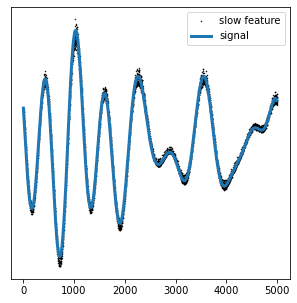

In [15]:
plt.figure(figsize=(5, 5))
# zscore to plot everyone together, and multiply by first elt sign to fix sign ambiguity
gevp_plot = zscore(slow_gevp[-5000:])
plt.plot(gevp_plot * np.sign(gevp_plot[0]), "k.", ms=1.0, label="slow feature")
plt.plot(true_s_plot, lw=3, label="signal")
plt.yticks([])
plt.legend()

# Offline "Bio"-SFA solution

In [16]:
# parameters
iters = 10**6
step = .1

In [17]:
# Initialize
W = rg.standard_normal((1,k))
W /= la.norm(W)
M = 1

In [18]:
# storage for metrics
off_slowness = np.zeros(iters)
for t in trange(iters, miniters=10000):
    dW = W @ Cxx_bar / M - W @ Cxx
    dM = (W @ Cxx_bar @ W.T) / (M * M) - M
    W += step * dW
    M += step * dM
    V = W / M
    V = V / la.norm(V @ Rxx)
    off_slowness[t] = V @ Cxx_dot @ V.T

100%|██████████| 1000000/1000000 [01:19<00:00, 12520.76it/s]


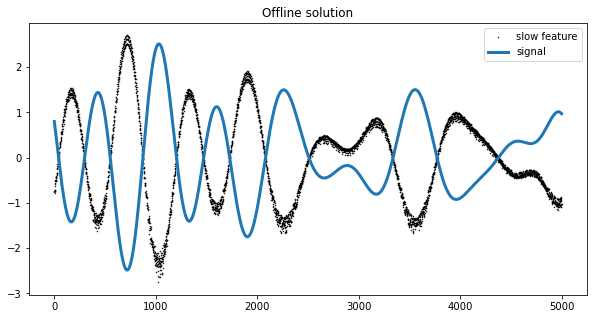

In [19]:
slow_off = W @ X / M
plt.figure(figsize=(10, 5))
# zscore to plot everyone together
plt.plot(zscore(slow_off[0,-5000:]), "k.", ms=1.0, label="slow feature")
plt.plot(true_s_plot, lw=3, label="signal")
plt.title("Offline solution")
plt.legend()
plt.show()

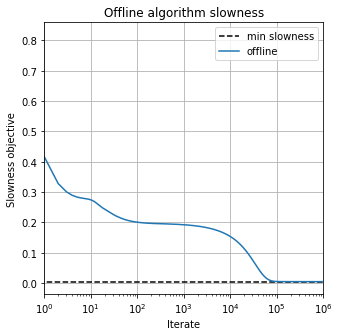

In [20]:
plt.figure(figsize=(5,5))
plt.semilogx([0, iters], [evals_dot[0]] * 2, 'k--', label="min slowness")
plt.semilogx(off_slowness, label="offline")
plt.xlabel("Iterate")
plt.ylabel("Slowness objective")
plt.title("Offline algorithm slowness")
plt.grid()
plt.xlim(1,iters)
plt.legend(loc="upper right")
plt.show()

# Online BioSFA solution

In [21]:
x_mean = X.mean(axis=1)

In [22]:
Minv, W, avg, history = biosfa.fit(
    X - x_mean[:, None], # input data
    1, # output dim
    2e-4, 2e-4, 1e8, # learning rate params
    num_epochs=50,
    pre_centered=True,
    colvar=False, rg=rg, dtype=float,
)

Epoch 1 / 50


100%|██████████| 999999/999999 [00:57<00:00, 17254.12it/s]

Epoch 2 / 50



100%|██████████| 999999/999999 [00:57<00:00, 17258.27it/s]

Epoch 3 / 50



100%|██████████| 999999/999999 [00:58<00:00, 17141.82it/s]

Epoch 4 / 50



100%|██████████| 999999/999999 [00:58<00:00, 17238.30it/s]

Epoch 5 / 50



100%|██████████| 999999/999999 [01:04<00:00, 15619.36it/s]

Epoch 6 / 50



100%|██████████| 999999/999999 [01:01<00:00, 16321.27it/s]

Epoch 7 / 50



100%|██████████| 999999/999999 [01:04<00:00, 15522.75it/s]

Epoch 8 / 50



100%|██████████| 999999/999999 [01:00<00:00, 16441.74it/s]

Epoch 9 / 50



100%|██████████| 999999/999999 [00:58<00:00, 17201.40it/s]

Epoch 10 / 50



100%|██████████| 999999/999999 [00:58<00:00, 17009.57it/s]

Epoch 11 / 50



100%|██████████| 999999/999999 [01:01<00:00, 16173.15it/s]

Epoch 12 / 50



100%|██████████| 999999/999999 [01:00<00:00, 16453.84it/s]

Epoch 13 / 50



100%|██████████| 999999/999999 [00:58<00:00, 17086.31it/s]

Epoch 14 / 50



100%|██████████| 999999/999999 [00:58<00:00, 17145.62it/s]

Epoch 15 / 50



100%|██████████| 999999/999999 [00:58<00:00, 17082.95it/s]

Epoch 16 / 50



100%|██████████| 999999/999999 [00:58<00:00, 17110.17it/s]

Epoch 17 / 50



100%|██████████| 999999/999999 [00:59<00:00, 16716.65it/s]

Epoch 18 / 50



100%|██████████| 999999/999999 [01:00<00:00, 16641.36it/s]

Epoch 19 / 50



100%|██████████| 999999/999999 [00:58<00:00, 17070.88it/s]

Epoch 20 / 50



100%|██████████| 999999/999999 [00:58<00:00, 17204.68it/s]

Epoch 21 / 50



100%|██████████| 999999/999999 [00:58<00:00, 17101.17it/s]

Epoch 22 / 50



100%|██████████| 999999/999999 [00:58<00:00, 17158.62it/s]

Epoch 23 / 50



100%|██████████| 999999/999999 [00:58<00:00, 17070.01it/s]

Epoch 24 / 50



100%|██████████| 999999/999999 [00:58<00:00, 17206.09it/s]

Epoch 25 / 50



100%|██████████| 999999/999999 [00:59<00:00, 16913.09it/s]

Epoch 26 / 50



100%|██████████| 999999/999999 [00:58<00:00, 17192.43it/s]

Epoch 27 / 50



100%|██████████| 999999/999999 [00:58<00:00, 17141.19it/s]

Epoch 28 / 50



100%|██████████| 999999/999999 [00:57<00:00, 17530.33it/s]

Epoch 29 / 50



100%|██████████| 999999/999999 [00:57<00:00, 17504.83it/s]

Epoch 30 / 50



100%|██████████| 999999/999999 [00:57<00:00, 17398.51it/s]

Epoch 31 / 50



100%|██████████| 999999/999999 [00:57<00:00, 17472.18it/s]

Epoch 32 / 50



100%|██████████| 999999/999999 [00:57<00:00, 17429.81it/s]

Epoch 33 / 50



100%|██████████| 999999/999999 [00:57<00:00, 17407.41it/s]

Epoch 34 / 50



100%|██████████| 999999/999999 [00:57<00:00, 17319.10it/s]

Epoch 35 / 50



100%|██████████| 999999/999999 [00:57<00:00, 17491.55it/s]

Epoch 36 / 50



100%|██████████| 999999/999999 [00:57<00:00, 17438.98it/s]

Epoch 37 / 50



100%|██████████| 999999/999999 [00:57<00:00, 17461.33it/s]

Epoch 38 / 50



100%|██████████| 999999/999999 [00:57<00:00, 17374.19it/s]

Epoch 39 / 50



100%|██████████| 999999/999999 [00:57<00:00, 17434.86it/s]

Epoch 40 / 50



100%|██████████| 999999/999999 [00:57<00:00, 17383.43it/s]

Epoch 41 / 50



100%|██████████| 999999/999999 [00:57<00:00, 17530.90it/s]

Epoch 42 / 50



100%|██████████| 999999/999999 [00:57<00:00, 17474.43it/s]

Epoch 43 / 50



100%|██████████| 999999/999999 [00:58<00:00, 17160.27it/s]

Epoch 44 / 50



100%|██████████| 999999/999999 [01:06<00:00, 15149.18it/s]

Epoch 45 / 50



100%|██████████| 999999/999999 [01:05<00:00, 15189.82it/s]

Epoch 46 / 50



100%|██████████| 999999/999999 [01:03<00:00, 15712.74it/s]

Epoch 47 / 50



100%|██████████| 999999/999999 [01:01<00:00, 16136.76it/s]

Epoch 48 / 50



100%|██████████| 999999/999999 [00:58<00:00, 17117.55it/s]

Epoch 49 / 50



100%|██████████| 999999/999999 [00:58<00:00, 17121.63it/s]

Epoch 50 / 50



100%|██████████| 999999/999999 [00:58<00:00, 17012.73it/s]


In [23]:
slow_online = Minv @ W @ (X[:, -5000:] - x_mean[:, None])

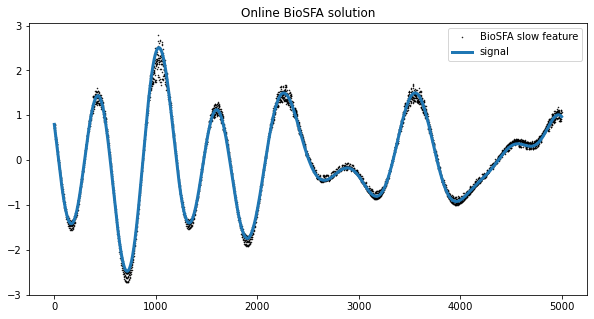

In [24]:
plt.figure(figsize=(10, 5))
# zscore to plot everyone together
plt.plot(zscore(slow_online[0]), "k.", ms=1.0, label="BioSFA slow feature")
plt.plot(true_s_plot, lw=3, label="signal")
plt.title("Online BioSFA solution")
plt.legend()
plt.show()

In [26]:
# -- convergence plot
# offline slowness
gevp_V = evecs_bar[:,-1:].T
gevp_V = la.inv(la.sqrtm(gevp_V @ Cxx @ gevp_V.T)) @ gevp_V
gevp_s = np.trace(gevp_V @ Cxx_dot @ gevp_V.T)

# online slowness history
slowness_errors = []
t, Minv_t, W_t = history
for Minv_, W_ in zip(Minv_t, W_t):
    V = Minv_ * W_
    V = la.inv(la.sqrtm(V @ Cxx @ V.T)) @ V
    slowness_errors.append(np.trace(V @ Cxx_dot @ V.T) - gevp_s)

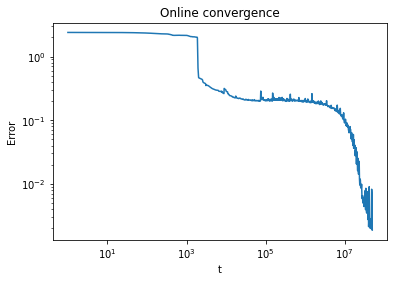

In [27]:
plt.loglog(t, slowness_errors)
plt.ylabel("Error")
plt.xlabel("t")
plt.title("Online convergence")
plt.show()